In [1]:
!pwd

/Users/sean/CloudStation/Metis/projects/project4/models


This cell enable importing functions from this project's src folder:

In [2]:
cd ..

/Users/sean/CloudStation/Metis/projects/project4


In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import punkt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from src.functions import get_sents
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
%matplotlib inline

See https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
for explanation of next cell:

In [4]:
%load_ext autoreload
%autoreload 2
#%autoreload?

In [5]:
raw_data_path = './data/raw/ted-talks/'
meta_data_filename = 'ted_main.csv'
transcripts_filename = 'transcripts.csv'
m_df = pd.read_csv(raw_data_path+meta_data_filename)
print('m_df:',m_df.shape)
t_df = pd.read_csv(raw_data_path+transcripts_filename)
print('t_df:',t_df.shape)

m_df: (2550, 17)
t_df: (2467, 2)


The dataframe t_df has all the transcripts.  I'll first break out the talks that contain the word love.

In [6]:
love=t_df[t_df['transcript'].str.contains('love',case=False)]
love.shape

(1175, 2)

The first talk that contains the word love: (uncomment and execute to view)

In [7]:
#love.iloc[0,0]

I was getting an error message that googling suggested the following line of code would cure:  It appears that it only had to be run once on my machine to provide the functionality it delivers.

In [8]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/sean/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Ok, I'm going to want the sentences that contains the word and some context so I'd be able to tell what the author is talking about.  I'm figuring that out in the cell below.

In [9]:
# Tokenize into sentences
df=pd.DataFrame(sent_tokenize(love.iloc[0,0]))
# Find only those sentences that contain the word love
df2=df[df[0].str.contains('love',case=False)]
# Get from 2 sentences before to 2 sentences after
df.iloc[df2.iloc[0].name-2:df2.iloc[0].name+2][0].str.cat(sep=' ')

'(Laughter)Well, I was born... no. (Laughter)I heard a great story recently — I love telling it — of a little girl who was in a drawing lesson. She was six, and she was at the back, drawing, and the teacher said this girl hardly ever paid attention, and in this drawing lesson, she did.'

Now I'll generalize that to find all the context snippets containing the word love.  I've placed this function into the file src/functions.py.

In [10]:
love_snippets = get_sents(love,'love')
print(love_snippets.shape)
love_snippets.columns

(1175, 5)


Index(['transcript', 'url', 'sentences', 'n_love_sents', 'love'], dtype='object')

I also kept track of (and returned) how many tokenized sentences containing the word each document had.  This is how it breaks out: (This gives some idea how sparse the word is across all the documents.)

In [11]:
print('# of     | # of')
print('sentences| documents')
love_snippets.n_love_sents.value_counts()
#Note value are not in order within value_counts

# of     | # of
sentences| documents


1     508
2     248
3     141
4      92
5      52
0      33
6      32
7      18
13      9
8       7
11      5
9       5
10      5
12      4
14      3
15      2
17      2
19      2
46      1
16      1
18      1
26      1
29      1
45      1
47      1
Name: n_love_sents, dtype: int64

Out of curiousity, what is the talk that has 46 sentences using 'love'?:

In [12]:
love_snippets[love_snippets.n_love_sents==46]

,transcript,url,sentences,n_love_sents,love
2276,"OK, so today I want to talk about how we talk ...",https://www.ted.com/talks/mandy_len_catron_a_b...,108,46,"OK, so today I want to talk about how we talk ..."


In [13]:
# love_snippets.loc[2276].love

Let's do topic modeling for 

In [14]:
cv1 = CountVectorizer(stop_words='english')
cv_doc_word = cv1.fit_transform(love_snippets.love)
cv_doc_word.shape

(1175, 15869)

For information: The following code shows the list of stop words currently used by scikit-learn's feature extraction tools:

In [15]:
# from sklearn.feature_extraction import stop_words
# print(sorted(stop_words.ENGLISH_STOP_WORDS))

In [16]:
cv_lsa=[]
cv_doc_topic=[]
for i in range(2,6):
    cv_lsa.append(TruncatedSVD(i))
    cv_doc_topic.append(cv_lsa[i-2].fit_transform(cv_doc_word))
    print(int(i),'topics variance ratios:',cv_lsa[i-2].explained_variance_ratio_)

2 topics variance ratios: [0.30156144 0.04896452]
3 topics variance ratios: [0.30156144 0.04896452 0.04181233]
4 topics variance ratios: [0.30156144 0.04896452 0.04181232 0.023413  ]
5 topics variance ratios: [0.30156144 0.04896452 0.04181231 0.0234137  0.02544239]


This is the topic_term matrix:

In [17]:
cv_lsa[0].components_

array([[ 1.09582596e-02,  1.72975510e-05,  1.70314777e-05, ...,
         2.20093803e-05,  3.92467561e-05,  3.48576542e-05],
       [-5.36652570e-03,  1.38818989e-06, -1.20572055e-05, ...,
         5.05686744e-05,  5.59809059e-05, -4.91715004e-06]])

In [18]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [19]:
cv_lsa[0]

TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
             random_state=None, tol=0.0)

In [20]:
display_topics(cv_lsa[0], cv1.get_feature_names(), 10)


Topic  0
love, just, people, like, think, know, romantic, really, laughter, want

Topic  1
come, wait, road, lies, free, ll, way, tennessee, hard, low


In [21]:
cv_doc_topic[0][:5,:]

array([[ 3.99054141,  1.0460552 ],
       [ 1.55186234, -0.08335892],
       [ 1.4464517 ,  0.04483494],
       [ 2.7491605 ,  1.08312244],
       [22.08475242, -0.82426863]])

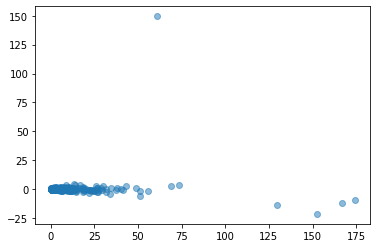

In [22]:
plt.scatter(cv_doc_topic[0][:,0],cv_doc_topic[0][:,1], alpha = 0.5);
# plt.axis([0, 60, -6, 10])

[0, 70, -6, 10]

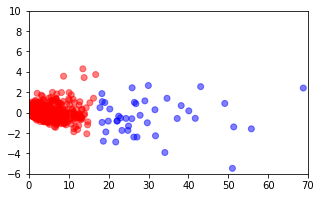

In [23]:
num_clusters = 4
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(cv_doc_topic[0])
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'k',4:'m',5:'y',6:'orange',7:'c',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
plt.figure(figsize=(5,3))
plt.scatter(cv_doc_topic[0][:,0],cv_doc_topic[0][:,1],c=col, alpha = 0.5);
plt.axis([0, 70, -6, 10])

There doesn't really seem to be a great collection of clusters in that 2D space!  However, some of the points are showing to be "outliers".  Let's look into them.

In [24]:
df = pd.DataFrame(cv_doc_topic[0])
df.head()

,0,1
0,3.990541,1.046055
1,1.551862,-0.083359
2,1.446452,0.044835
3,2.749160,1.083122
4,22.084752,-0.824269


These are the rows of the doc_topic array that are "interesting"...

In [25]:
df.loc[df.iloc[:,1].idxmax()]   # index of the single high y "outlier":

0     60.698949
1    149.507558
Name: 1134, dtype: float64

In [26]:
df[df.iloc[:,0]>100]   # indices of 4 high x "outliers":

,0,1
16,152.242037,-21.333742
116,167.026379,-11.680976
918,129.729722,-13.984961
1073,174.207001,-9.522836


Change ind below to each of the "interesting" indices above to see the text scored.  
Note: Uncomment last line to see entry.

In [27]:
ind=1134
print(love_snippets.iloc[ind].n_love_sents)
# love_snippets.iloc[ind].love

14


Let me center and normalize the 2 topic results:

/Users/sean/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/Users/sean/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


[-1, 1, -1, 1]

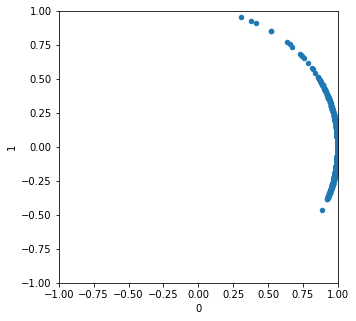

In [28]:
# x_mean, y_mean = df.mean()
x_mean, y_mean = 0,0

df2=df.copy()
for i,row in df.iterrows():
    x, y = row[0].copy()-x_mean,row[1].copy()-y_mean
    df2.iloc[i,0]=x/(x**2+y**2)**0.5
    df2.iloc[i,1]=y/(x**2+y**2)**0.5
df2.plot.scatter(x=0,y=1,figsize=(5,5));
plt.axis([-1,1,-1,1])

[-1, 1, -1, 1]

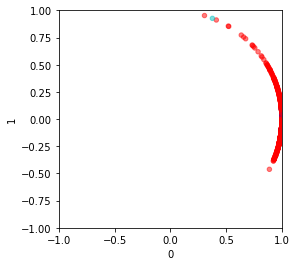

In [29]:

# num_clusters = 3
# km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
# km.fit(df2)
# km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df2.plot.scatter(x=0,y=1,figsize=(4,4), c=col, alpha = 0.5);
plt.axis([-1,1,-1,1])
# plt.savefig("reports/figures/figure_1.png")

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
tfidf1 = TfidfVectorizer(stop_words='english')
doc_words_tfidf1 = tfidf1.fit_transform(love_snippets.love)
doc_words_tfidf1.shape

(1175, 15869)

In [32]:
tfidf_lsa=[]
tfidf_doc_topic=[]
for i in range(2,7):
    tfidf_lsa.append(TruncatedSVD(i))
    tfidf_doc_topic.append(tfidf_lsa[i-2].fit_transform(doc_words_tfidf1))
    print(int(i),'topics variance ratios:',tfidf_lsa[i-2].explained_variance_ratio_)

2 topics variance ratios: [0.00473065 0.00376975]
3 topics variance ratios: [0.00473065 0.00373164 0.0032699 ]
4 topics variance ratios: [0.00473065 0.00376182 0.00328415 0.00320763]
5 topics variance ratios: [0.00473065 0.00376135 0.00330446 0.00318553 0.00300327]
6 topics variance ratios: [0.00473065 0.00372373 0.00330443 0.00320438 0.00296426 0.00290201]


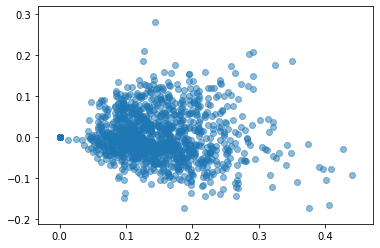

In [33]:
plt.scatter(tfidf_doc_topic[0][:,0],tfidf_doc_topic[0][:,1], alpha = 0.5);

In [34]:
num_clusters = 4
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=1) # n_init, number of times the K-mean algorithm will run
km.fit(tfidf_doc_topic[4])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=10, tol=0.0001, verbose=0)

In [35]:
from sklearn.manifold import TSNE
from itertools import cycle

In [36]:
model = TSNE(n_components=2, random_state=0,verbose=1)
low_data = model.fit_transform(tfidf_doc_topic[4])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1175 samples in 0.000s...
[t-SNE] Computed neighbors for 1175 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1175
[t-SNE] Computed conditional probabilities for sample 1175 / 1175
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.218498
[t-SNE] KL divergence after 1000 iterations: 1.486049


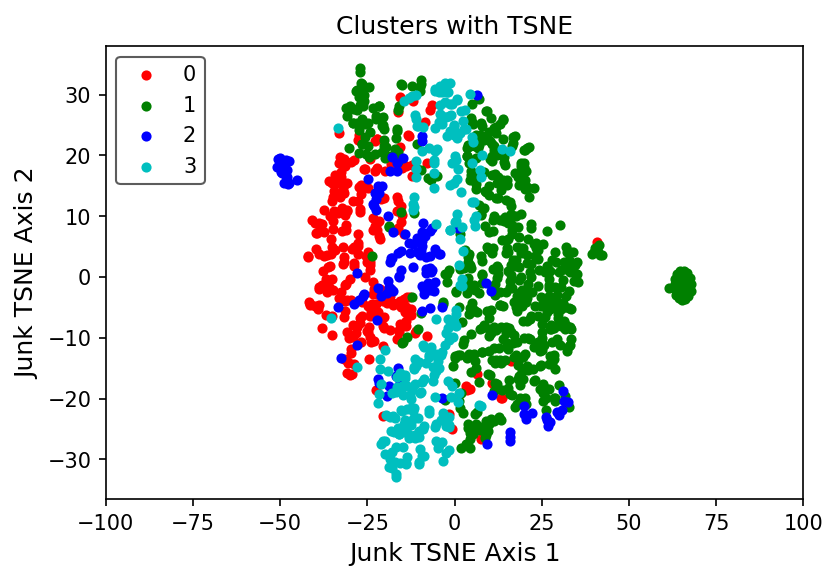

In [37]:
target = km.labels_
target_names = range(num_clusters)
#target_names = digits.target_names

colors = cycle(['r','g','b','c','m','y','orange','k','aqua','yellow'])
target_ids = range(len(target_names))
plt.figure(dpi=150)
for i, c, label in zip(target_ids, colors, target_names):
    plt.scatter(low_data[target == i, 0], low_data[target == i, 1], c=c, label=label, s=15, alpha=1)
plt.legend(fontsize=10, loc='upper left', frameon=True, facecolor='#FFFFFF', edgecolor='#333333')
plt.xlim(-100,100);
plt.title("Clusters with TSNE", fontsize=12)
plt.ylabel("Junk TSNE Axis 2", fontsize=12)
plt.xlabel("Junk TSNE Axis 1", fontsize=12);
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);